In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras.utils import to_categorical

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def load_data(datafile):
    dataset = pd.read_csv(datafile)
    return dataset

df = load_data("cover_data.csv")

In [3]:
def dataset_statistics(dataframe):
    print("Dataset statistics:")
    display(dataframe.describe())
    print("\nData shape:", dataframe.shape)
    display("\nData info:", dataframe.info())

dataset_statistics(df)

Dataset statistics:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000



Data shape: (581012, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2          

'\nData info:'

None

In [4]:
# Continious variables method
continuous_variables = ["Elevation",
                         "Aspect", 
                         "Slope", 
                         "Horizontal_Distance_To_Hydrology", 
                         "Vertical_Distance_To_Hydrology", 
                         "Horizontal_Distance_To_Roadways", 
                         "Hillshade_9am", "Hillshade_Noon", 
                         "Hillshade_3pm", 
                         "Horizontal_Distance_To_Fire_Points",]
def dist_cont_var(dataframe, vars):
    plt.figure(figsize=(15,15))
    i = 1
    for var in vars:
        ax = plt.subplot(5,2,i)
        sns.histplot(dataframe, x=var, bins=50)
        ax.set_title(f"{var} Distribution")
        ax.set_xlabel(f"{var}")
        i += 1
    plt.tight_layout()
    plt.show()

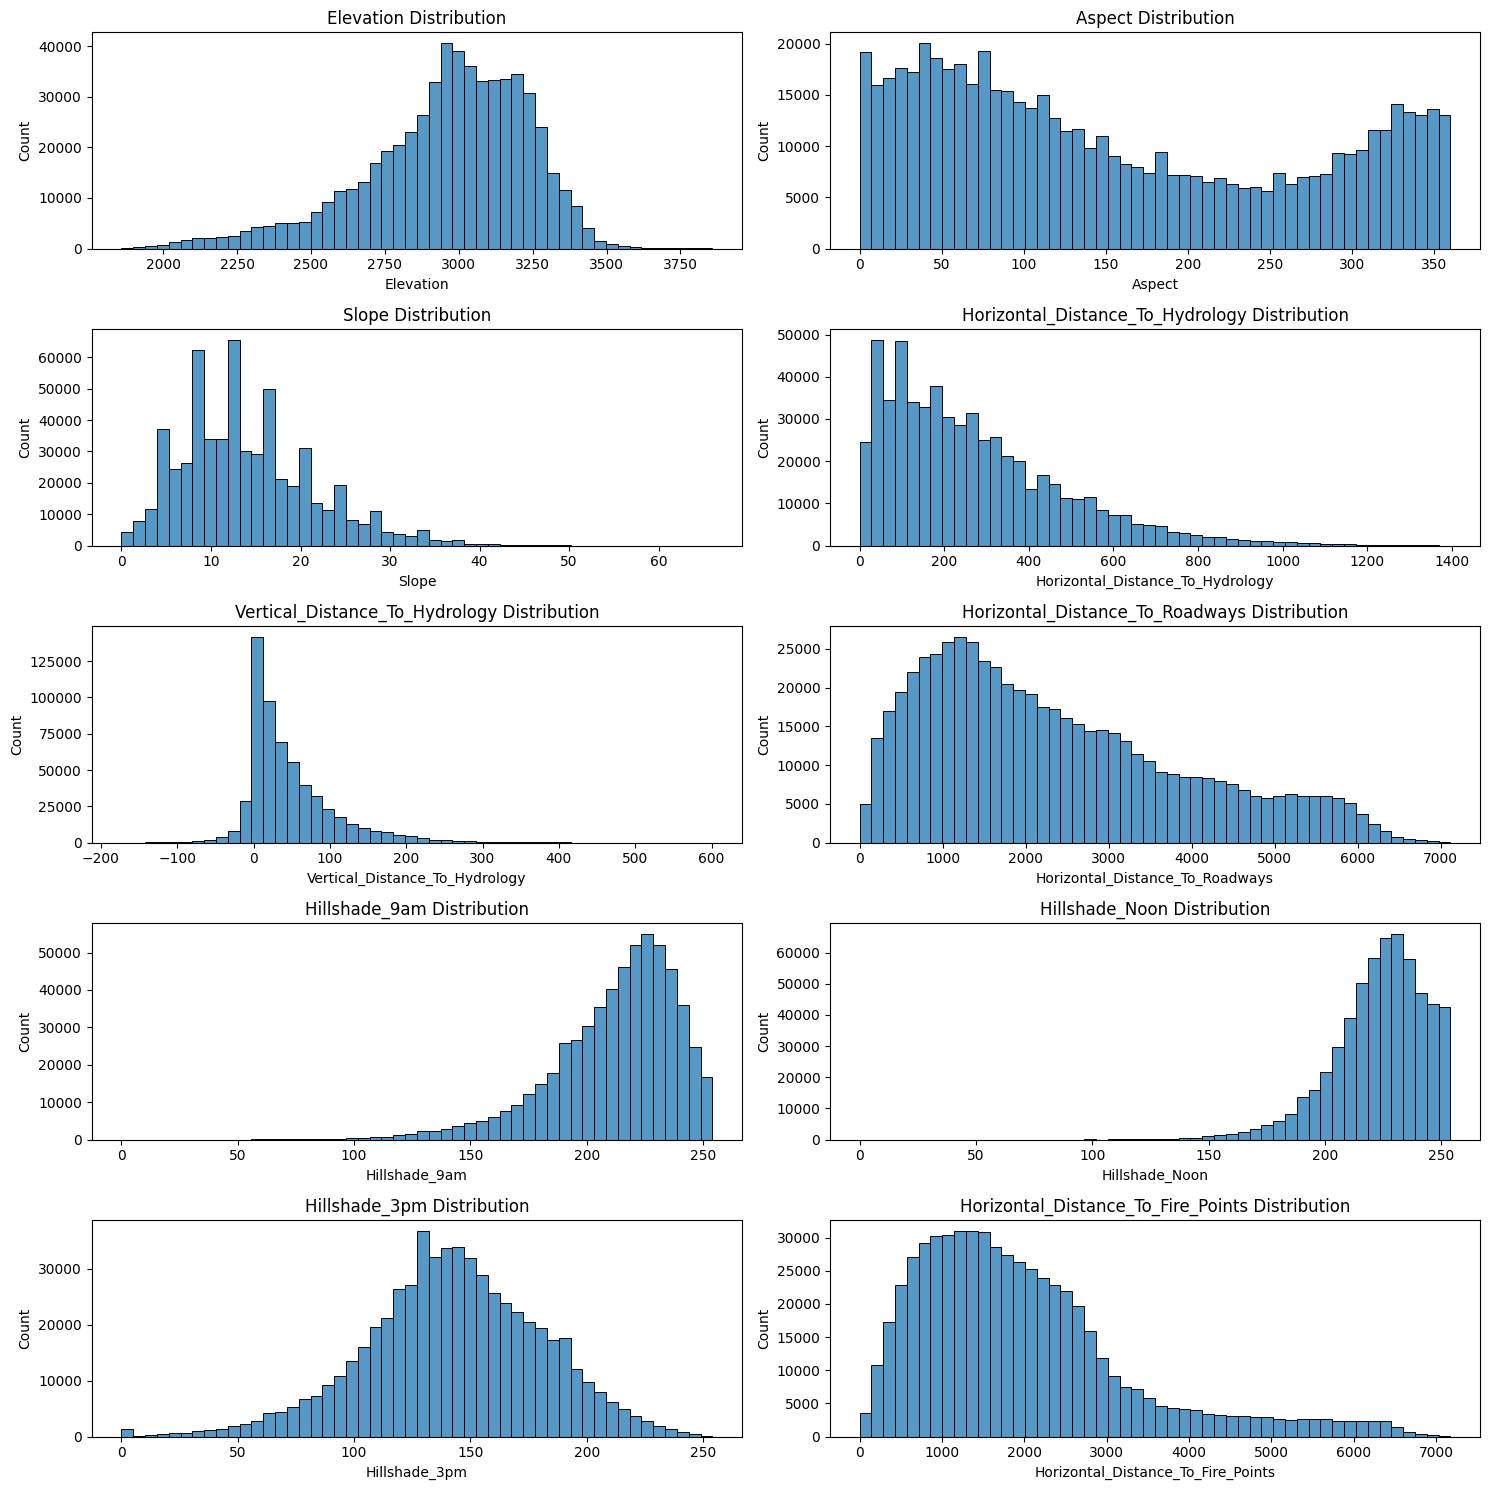

In [5]:
# Plot distributions
dist_cont_var(df, continuous_variables)  

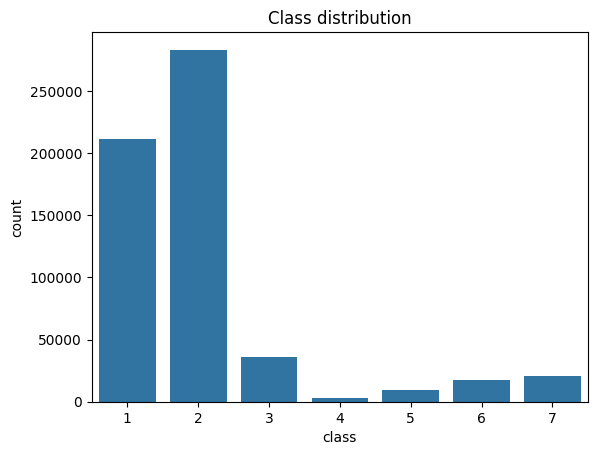

In [6]:
#plot the class distribution
def dist_class(df,class_var):
    sns.countplot(data=df, x=class_var)
    plt.title("Class distribution")
    plt.show()
    plt.close()

dist_class(df, 'class')

In [7]:
# one hot encoding for the class
y_to_cat = to_categorical(df["class"], 8)

In [8]:
# split the data into train and test classes
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1),
                                                    y_to_cat,
                                                    test_size=0.2,
                                                    random_state=42)

In [9]:
# build the model
def build_model():
    model = Sequential() 
    model.add(keras.Input(shape=(54,)))
    model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    #compile the model 
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["categorical_accuracy", "auc"])
    return model

model = build_model()

In [10]:
display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,264 (24.47 KB)

 Trainable params: 6,264 (24.47 KB)

 Non-trainable params: 0 (0.00 B)

None

In [11]:
#fit the model
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             mode = "min",
                                             patience=10)])

Epoch 1/50
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 11s 885us/step - auc: 0.8942 - categorical_accuracy: 0.5156 - loss: 2.7797 - val_auc: 0.9595 - val_categorical_accuracy: 0.7025 - val_loss: 0.7240
Epoch 2/50
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 10s 856us/step - auc: 0.9580 - categorical_accuracy: 0.6943 - loss: 0.7307 - val_auc: 0.9552 - val_categorical_accuracy: 0.6910 - val_loss: 0.7527
Epoch 3/50
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 10s 884us/step - auc: 0.9624 - categorical_accuracy: 0.7127 - loss: 0.6863 - val_auc: 0.9657 - val_categorical_accuracy: 0.7274 - val_loss: 0.6536
Epoch 4/50
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 10s 881us/step - auc: 0.9646 - categorical_accuracy: 0.7219 - loss: 0.6661 - val_auc: 0.9642 - val_categorical_accuracy: 0.7120 - val_loss: 0.6674
Epoch 5/50
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 10s 870us/step - auc: 0.9657 - categorical_accuracy: 0.7254 - loss: 0.6553 - val_auc: 0.9644 - val_categorical_accuracy: 0.7115 - val_loss: 0.6613
Epoch 6/50
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 1

In [12]:
#evalute the model on the training data
results = model.evaluate(X_train, y_train)
categorical_accuracy, auc = results[1], results[2]
print(f"AUC: {auc}, Categorical_accuracy: {categorical_accuracy}")

14526/14526 ━━━━━━━━━━━━━━━━━━━━ 12s 849us/step - auc: 0.9763 - categorical_accuracy: 0.7779 - loss: 0.5471
AUC: 0.9765673875808716, Categorical_accuracy: 0.7790640592575073


In [13]:
# Evaluate the model on the test data
pred = model.predict(X_test)

# Convert one-hot encoded labels back to their original form
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(pred, axis=1)

# Classification report
report = classification_report(true_labels, predicted_labels)
print(report)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 815us/step
              precision    recall  f1-score   support

           1       0.77      0.79      0.78     42557
           2       0.81      0.82      0.81     56500
           3       0.67      0.88      0.76      7121
           4       0.00      0.00      0.00       526
           5       0.00      0.00      0.00      1995
           6       0.50      0.29      0.37      3489
           7       0.84      0.72      0.77      4015

    accuracy                           0.78    116203
   macro avg       0.51      0.50      0.50    116203
weighted avg       0.76      0.78      0.76    116203



c:\Users\cuate\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cuate\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cuate\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

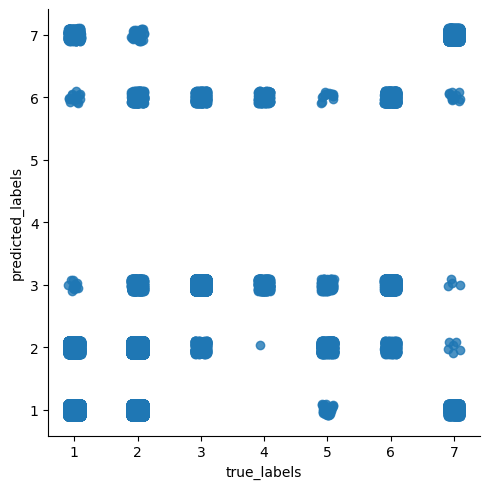

In [14]:
# create a dataframe for the predicted and true labels
df_pred = pd.DataFrame(zip(true_labels, predicted_labels), columns=["true_labels", "predicted_labels"])
df_pred["results"] = df_pred["true_labels"] == df_pred["predicted_labels"]


sns.lmplot(data = df_pred,
            x = "true_labels",
            y="predicted_labels",
            x_jitter=0.1, 
            y_jitter=0.1,
            fit_reg=False)
plt.show()
plt.close()

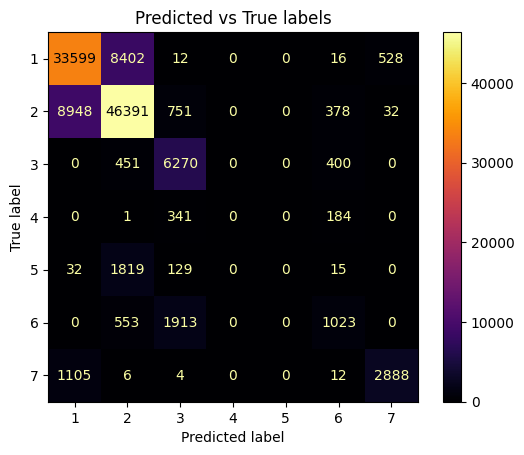

In [15]:
# Assuming true_labels and predicted_labels are defined
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

# Define the labels you want to display
labels = [1, 2, 3, 4, 5, 6, 7]

# Plot the confusion matrix with custom labels and no grid
fig, ax = plt.subplots()
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=labels)
cm_display.plot(ax=ax, cmap="inferno")
ax.grid(False) # disable grid
ax.set_title("Predicted vs True labels")
plt.show()
plt.close()

In [16]:
print(history.history.keys())

dict_keys(['auc', 'categorical_accuracy', 'loss', 'val_auc', 'val_categorical_accuracy', 'val_loss'])


In [17]:
def plot_model_results(history):
    plt.figure(figsize=(8, 8))
    sns.set_style("darkgrid")
    # Plot train and validation loss
    plt.subplot(2,2,1)
    sns.lineplot(history.history['loss'], label='Train Loss')
    sns.lineplot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(2,2,2)
    sns.lineplot(history.history['categorical_accuracy'], label='Train Acc')
    sns.lineplot(history.history['val_categorical_accuracy'], label='Validation Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
   
    # Plot train and validation AUC
    plt.subplot(2,2,3)
    sns.lineplot(history.history['auc'], label='Train AUC')
    sns.lineplot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model ACU')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplots_adjust(wspace=0.3, hspace= 0.3)
    plt.show()
    plt.close()

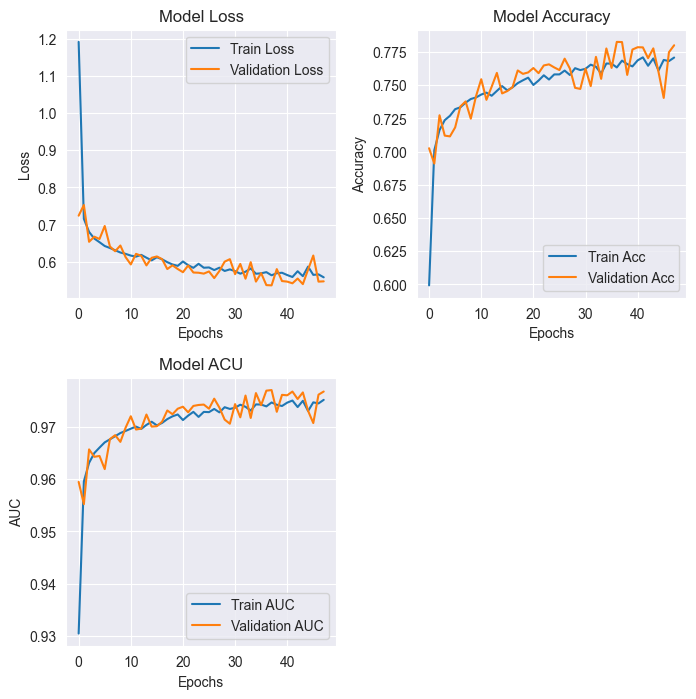

In [18]:
plot_model_results(history)

In [23]:
#model wrapper
model_grid_search = KerasClassifier(model = build_model, verbose=0)

# define the columns transformer as a touple ct([(x,y)])
ct = ColumnTransformer([("STD", StandardScaler(),continuous_variables),],
                       remainder='passthrough',
                       force_int_remainder_cols = False)

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', ct),
                           ('model', model_grid_search)])

#Setting up the grid search
param_grid = {'model__batch_size': [10, 20],
              'model__epochs': [5],
              #'model__validation_split' : [0.1, 0.2],
              'model__optimizer': ['adam', 'rmsprop']
              }

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid=param_grid,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('STD',
                                                                         StandardScaler(),
                                                                         ['Elevation',
                                                                          'Aspect',
                                                                          'Slope',
                                                                          'Horizontal_Distance_To_Hydrology',
                                                                          'Vertical_Distance_To_Hydrology',
                                                                          'Horizontal_Distance_To_Roadways',
                                                                          'Hillshade_9am',
                                                                          'Hillshade_Noon',
                                                                          'Hillshade_3pm',
                                                                          'Horizontal_Distance_To_Fire_Points'])])),
                                       ('model',
                                        KerasClassifier(model=<function build_model at 0x000001FA2A8163E0>, verbose=0))]),
             n_jobs=-1,
             param_grid={'model__batch_size': [10, 20], 'model__epochs': [5],
                         'model__optimizer': ['adam', 'rmsprop']},
             verbose=2)

In [24]:
# Best parameter set
print('Best parameters found:\n', grid_search.best_params_)

#Print the hyperparameter grid
hyperparameter_grid = pd.DataFrame(grid_search.cv_results_['params'])
grid_scores = pd.DataFrame(grid_search.cv_results_['mean_test_score'], columns = ['score'])
display(pd.concat([hyperparameter_grid, grid_scores], axis = 1))

# Score with test data and the best parameters
print(f'The model performance with best parameters is: {grid_search.score(X_test, y_test)}')

Best parameters found:
 {'model__batch_size': 10, 'model__epochs': 5, 'model__optimizer': 'rmsprop'}


,model__batch_size,model__epochs,model__optimizer,score
0,10,5,adam,0.850076
1,10,5,rmsprop,0.852094
2,20,5,adam,0.842778
3,20,5,rmsprop,0.843977


The model performance with best parameters is: 0.858334122182732
